# Compute the difference of atmospheric dispersion for parallel obs
by myriam.rodrigues@obspm.fr

This notebook computes the drift of the spot image due to the atmospheric difraction during paralle observations. It assumes that the VIS band is used as reference wavelength for guiding. The NIR aperture is placed on the spot image at mid-band at the start of aquisition. The NIR apertures do not correct for the AD shift, but are affected by the shift indiced by the follow-up of the VIS apertures. 

Change log
Date	Description
23/03/2022	Draft


In [4]:
from configobj import ConfigObj
import subprocess
import os, sys
import math
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Markdown
from astropy.table import Table, Column
from astropy.io import ascii
from astropy.coordinates import SkyCoord,Angle
from astropy.time import Time
from astroplan import Observer
from Atmospheric_diffraction import *
%matplotlib inline 

plt.rcParams['figure.figsize'] = (12,4)

In [5]:
#Computes a range of airmass for a Target at a given Latitude and for a range of Hour Angles.

def airmass_from_Target_Loc(Latitude,Declination,HA_array):
  airmass_array = np.array([])
  for HA in HA_array:
    HA_deg = Angle(HA * u.hour)
    airmass = 1./ (np.sin(Latitude.rad)*np.sin(Declination.rad)+np.cos(Latitude.rad)*np.cos(Declination.rad)*np.cos(HA_deg.rad))
    airmass_array=np.append(airmass_array,airmass)
  return airmass_array
print(Paranal.location.lat)

-24d37m38.781876s


### Computes airmass of a target for a range of hour angles

In [6]:
#Set observatory to Paranal
Paranal = Observer.at_site('Cerro Paranal') 
lat=-24.6272 * u.deg
#Some typical targets
HDFS = SkyCoord('22h32m56.0s', frame='icrs')
LMC = SkyCoord('05h23m34.6s', '-69d45m22.0s', frame='icrs', unit='deg')

#Plot Airmass for a range of Hour Angle
HA = np.arange(-3,3,0.2) # hours
airmass_LMC = airmass_from_Target_Loc(Paranal.location.lat,LMC.dec,HA)
airmass_HDFS = airmass_from_Target_Loc(Paranal.location.lat,HDFS.dec,HA)

plt.figure(1)
plt.style.use('bmh')
plt.plot(HA,airmass_LMC,  linewidth=1.5, label= 'LMC')
plt.plot(HA,airmass_HDFS,  linewidth=1.5, label= 'HDFS')
plt.legend(loc='best')
plt.ylabel('Airmass')
plt.xlabel('Hour Angle [hour]')


ValueError: ('Cannot parse first argument data "" for attribute dec', ValueError("Syntax error parsing angle ''"))

### Simulate parallele observation in VIS- and NIR- MOS observations

Guiding is done in the VIS-band and the position of the NIR-MOS sub-field is corrected for the Atmospheric dispersion at t=0 (mid wavelength of the NIR band)

In [7]:
#Difference of airmass between start of observation and end
Target = HDFS

HA_range = np.array([2,3])
Airmass_SF = airmass_from_Target_Loc(Paranal.location.lat,Target.dec,HA_range)
Airmass_Diff = HA_range[1] - HA_range[0]
Airmass_mean = np.average(Airmass_SF)

print("HA - Start = %4.2fh" % (HA_range[1]))
print("HA - End = %4.2f" % (HA_range[0]))
print("Mean Airmass = %4.2f" % (Airmass_mean))
print("Delta Airmass = %4.2f" % (Airmass_Diff))

NameError: name 'HDFS' is not defined

In [8]:
#Import Environmental condition and MOSAIC configuration
Path_Inst_config = './Architecture_parameters/'
Config_tel = ConfigObj(Path_Inst_config+'Telescope_conf.ini')

conditions = {}
conditions['temperature']= float(Config_tel['EnvConditions']['AirTemperature']) * u.deg_C
conditions['humidity']= float(Config_tel['EnvConditions']['AirHumidity']) * u.percent
conditions['pressure']= float(Config_tel['EnvConditions']['AirPressure']) * u.mBa

In [9]:
Config_VIS = ConfigObj(Path_Inst_config+'VIS_channel_conf.ini')
VIS_Band = 'V'
wave_VIS = np.arange(int(Config_VIS['LR']['Bands'][VIS_Band]['wave_min']),int(Config_VIS['LR']['Bands'][VIS_Band]['wave_max']),50) * u.nm

#Guiding in VIS 
wave_ref = np.mean(wave_VIS) # 0.800 * u.micron 
print(wave_ref)

#AD in VIS sub-fields at t_start
shift_VIS = Atmospheric_diffraction(wave_VIS, Airmass_SF[0], wave_ref, conditions)
#AD in VIS sub-fields at t_final
shift_VIS_f = Atmospheric_diffraction(wave_VIS, Airmass_SF[1], wave_ref, conditions)



537.0 nm


NameError: name 'Airmass_SF' is not defined

In [10]:
Config_NIR = ConfigObj(Path_Inst_config+'NIR_channel_conf.ini')
wave_NIR = np.arange(int(Config_NIR['LR']['Bands']['IY']['wave_min']),int(Config_NIR['LR']['Bands']['H']['wave_max']),50) * u.nm

#At t=0, NIR sub-fields are center 
wave_NIR_c = np.mean(wave_NIR) * 0.8 #why 0.8?
#Compute the shift to center the NIR bundle at t=0 
Shif_NIR_c = Atmospheric_diffraction(wave_NIR_c, Airmass_SF[0], wave_ref, conditions) 
print("Shift NIR bundle by %4.2f[arcsec] at aquisition" % (Shif_NIR_c.value))

# AD at t=0 for NIR bundle
shift_NIR_s = Atmospheric_diffraction(wave_NIR, Airmass_SF[0], wave_ref, conditions) - Shif_NIR_c
#At t_final, the shift in NIR sub-fields due to the shift in VIS from guiding
shift_NIR_f = Atmospheric_diffraction(wave_NIR, Airmass_SF[1], wave_ref, conditions) - Shif_NIR_c


#To compensate for the guiding, need to move NIR bundle by
shift_NIR_cf = Atmospheric_diffraction(wave_NIR_c, Airmass_SF[1], wave_ref, conditions) 
print("Shift for NIR bundles to compensate for the AD correction in VIS = %4.2f[arcsec]" % (shift_NIR_cf.value - Shif_NIR_c.value))




NameError: name 'Airmass_SF' is not defined

NameError: name 'HA_range' is not defined

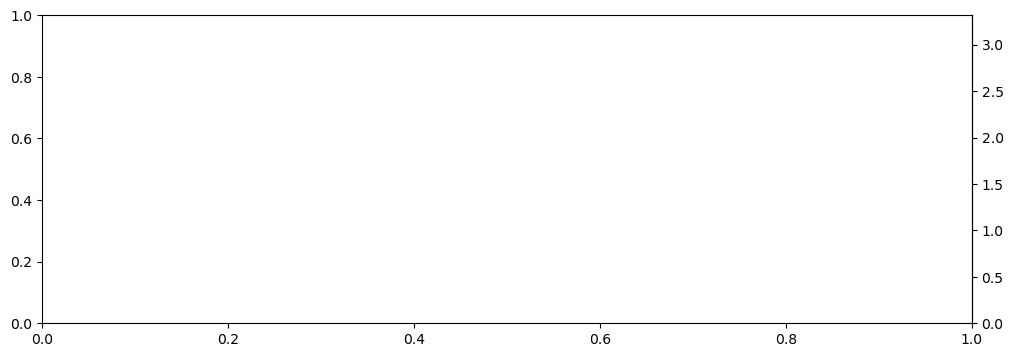

In [11]:
#Convert shift in arcsec to mm in focal plane
Plate_scale = float(Config_tel['OpticalInterfaces']['Plate_Scale']) #* u.arcsec / u.mm
T_arc = lambda T_mm: T_mm * Plate_scale
T_mm = lambda T_arc: T_arc / Plate_scale

fig, ax = plt.subplots()
ax2 = ax.secondary_yaxis("right", functions=(T_arc, T_mm))
plt.style.use('bmh')

for i in range(0,len(HA_range)):
    shift_VIS = Atmospheric_diffraction(wave_VIS, Airmass_SF[i], wave_ref, conditions)

    plt.plot(wave_VIS, (shift_VIS),  linewidth=1.5, label= 'VIS t={}h'.format(HA_range[i]) %(wave_ref))
#plt.plot(wave_VIS, (shift_VIS_f),  linewidth=1.5, label= 'VIS t={}h'.format(HA_range[0]) %(wave_ref))

# plt.plot(wave_NIR, (shift_NIR_s),  linewidth=1.5, label= 'NIR t=0' %(wave_ref))
# plt.plot(wave_NIR, (shift_NIR_f),  linewidth=1.5, label= 'NIR t=1h' %(wave_ref))

plt.title('wavelength reference %s' %(wave_ref))
plt.legend(loc='best')
ax.set_ylabel('AD shift [arcsec]')
ax2.set_ylabel('AD shift [mm]')
ax.set_xlabel('Wavelength [nm]')

NameError: name 'shift_NIR_s' is not defined

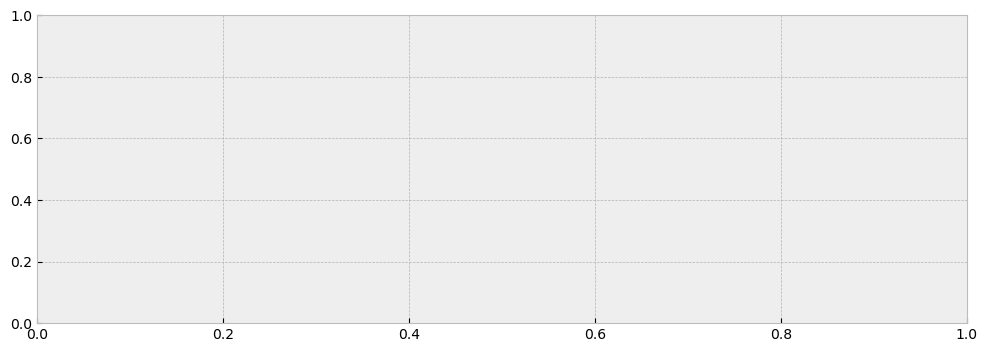

In [12]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

fig, ax = plt.subplots()
xvals=np.linspace(-1,1,len(wave_NIR))
c=np.tan(xvals)


HA_val=0
yvals=np.full(len(shift_NIR_s),HA_val)
plt.scatter(shift_NIR_s,yvals,c=c)

norm = plt.Normalize(wave_NIR.value.min(), wave_NIR.value.max())
points = np.array([shift_NIR_s, yvals]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(wave_NIR.value)
lc.set_linewidth(2)
line=ax.add_collection(lc)
fig.colorbar(line)



HA_val=1
yvals=np.full(len(shift_NIR_f),HA_val)
plt.scatter(shift_NIR_f,yvals,c=c)

norm = plt.Normalize(wave_NIR.value.min(), wave_NIR.value.max())
points = np.array([shift_NIR_f, yvals]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(wave_NIR.value)
lc.set_linewidth(2)
line=ax.add_collection(lc)



plt.ylim(0,5)
plt.xlabel('Displacement [arcsec]')
plt.ylabel('Hour Angle [h]')

print(wave_NIR_c)
plt.title("Wavelength Reference: {}".format(wave_ref))

1036.0 nm


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


Text(0.5, 1.0, 'Wavelength Reference: 537.0 nm')

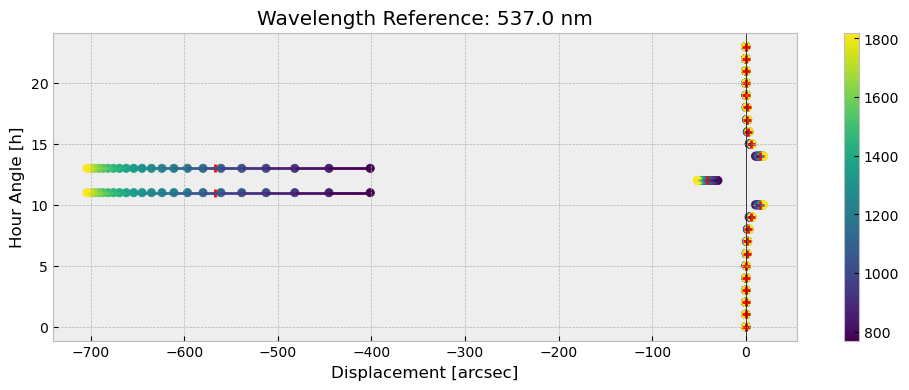

In [20]:
Test = SkyCoord('22h32m56.0s', '-64d33m00.0s', frame='icrs')
Target = Test

fig, ax = plt.subplots()
xvals=np.linspace(-1,1,len(wave_NIR))
c=np.tan(xvals)

HA_range = np.linspace(0,23,24)
Airmass_SF = airmass_from_Target_Loc(Paranal.location.lat,Target.dec,HA_range)
plt.axvline(0,linewidth=0.5,color='black')
start=0
end=24
Shif_NIR_c = Atmospheric_diffraction(wave_NIR_c, Airmass_SF[start], wave_ref, conditions)
for i in range(start,end):
    shift_NIR = Atmospheric_diffraction(wave_NIR, Airmass_SF[i], wave_ref, conditions) - Shif_NIR_c
    HA_val=HA_range[i]
    yvals=np.full(len(shift_NIR),HA_val)
    plt.scatter(shift_NIR,yvals,c=c)

    norm = plt.Normalize(wave_NIR.value.min(), wave_NIR.value.max())
    points = np.array([shift_NIR, yvals]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(wave_NIR.value)
    lc.set_linewidth(2)
    line=ax.add_collection(lc)

    shift_NIR_f = Atmospheric_diffraction(wave_NIR_c, Airmass_SF[i], wave_ref, conditions)
    plt.scatter(shift_NIR_f-Shif_NIR_c,HA_val,marker='+',color='r')
fig.colorbar(line)


#plt.ylim(start-0.5,end-1+0.5)
plt.xlabel('Displacement [arcsec]')
plt.ylabel('Hour Angle [h]')

print(wave_NIR_c)
plt.title("Wavelength Reference: {}".format(wave_ref))

1036.0 nm


/opt/anaconda3/envs/astrocondatest/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


Text(0.5, 1.0, 'Wavelength Reference: 537.0 nm')

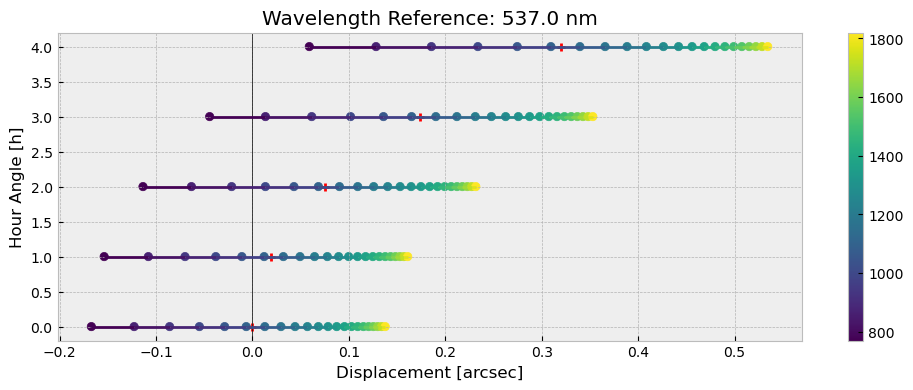

In [19]:
fig, ax = plt.subplots()
xvals=np.linspace(-1,1,len(wave_NIR))
c=np.tan(xvals)
plt.axvline(0,linewidth=0.5,color='black')
HA_range = np.linspace(0,23,24)
Airmass_SF = airmass_from_Target_Loc(Paranal.location.lat,Target.dec,HA_range)

start=0
end=5
Shif_NIR_c = Atmospheric_diffraction(wave_NIR_c, Airmass_SF[start], wave_ref, conditions)
for i in range(start,end):
    shift_NIR = Atmospheric_diffraction(wave_NIR, Airmass_SF[i], wave_ref, conditions) - Shif_NIR_c
    HA_val=HA_range[i]
    yvals=np.full(len(shift_NIR),HA_val)
    plt.scatter(shift_NIR,yvals,c=c)

    norm = plt.Normalize(wave_NIR.value.min(), wave_NIR.value.max())
    points = np.array([shift_NIR, yvals]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    lc.set_array(wave_NIR.value)
    lc.set_linewidth(2)
    line=ax.add_collection(lc)

    shift_NIR_f = Atmospheric_diffraction(wave_NIR_c, Airmass_SF[i], wave_ref, conditions)
    plt.scatter(shift_NIR_f-Shif_NIR_c,HA_val,marker='+',color='r')
fig.colorbar(line)


#plt.ylim(start-0.5,end-1+0.5)
plt.xlabel('Displacement [arcsec]')
plt.ylabel('Hour Angle [h]')

print(wave_NIR_c)
plt.title("Wavelength Reference: {}".format(wave_ref))

In [16]:
Target.dec

AttributeError: Latitude instance has no attribute 'u'